In [1]:
# Install required libraries
!pip install tensorflow matplotlib numpy scikit-learn

# Import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

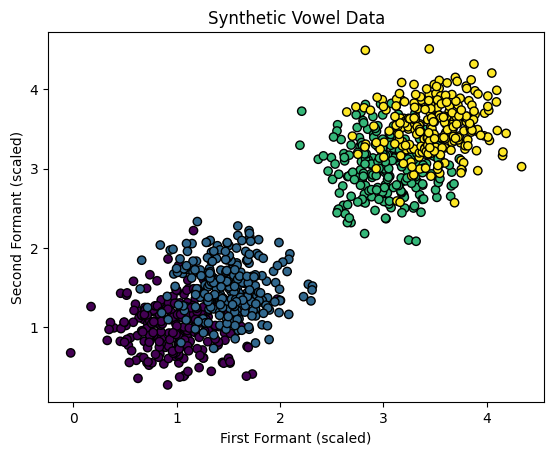

Shape of X: (1000, 2), Shape of y: (1000,)


In [2]:
# Generate synthetic vowel data
def generate_vowel_data(num_samples=1000):
    np.random.seed(42)
    class_labels = ['[i]', '[ɪ]', '[a]', '[ɑ]']  # Vowel class labels
    means = [[1, 1], [1.5, 1.5], [3, 3], [3.5, 3.5]]  # Centers for clusters
    covs = [np.eye(2) * 0.1 for _ in range(4)]  # Small variances for overlap
    X, y = [], []
    for i, (mean, cov) in enumerate(zip(means, covs)):
        data = np.random.multivariate_normal(mean, cov, num_samples // 4)
        X.append(data)
        y.extend([i] * (num_samples // 4))
    return np.vstack(X), np.array(y)

# Generate and visualize the data
X, y = generate_vowel_data()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title("Synthetic Vowel Data")
plt.xlabel("First Formant (scaled)")
plt.ylabel("Second Formant (scaled)")
plt.show()

# Print shape of data
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

## 3. Preprocess and Split Data
Standardize the features and split into training and testing datasets.

In [3]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check preprocessed data
print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")
print(f"Sample of standardized X_train: {X_train[:5]}")

Training Data Shape: (800, 2), Testing Data Shape: (200, 2)
Sample of standardized X_train: [[-1.05003152 -0.86885738]
 [ 0.67724795  0.81535169]
 [ 0.82448823  0.48153195]
 [ 0.73457038  0.78295138]
 [ 1.03636407  0.86787445]]


In [4]:
# Define expert networks
def create_expert(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8, activation='relu', input_dim=input_dim),
        tf.keras.layers.Dense(4, activation='softmax')  # Output probabilities for 4 classes
    ])
    return model

# Define gating network
def create_gating_network(input_dim, num_experts):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8, activation='relu', input_dim=input_dim),
        tf.keras.layers.Dense(num_experts, activation='softmax')  # Output mixing proportions
    ])
    return model

In [5]:
# Combine experts and gating network into Mixture of Experts
class MixtureOfExperts(tf.keras.Model):
    def __init__(self, input_dim, num_experts, num_classes):
        super(MixtureOfExperts, self).__init__()
        self.experts = [create_expert(input_dim) for _ in range(num_experts)]
        self.gating_network = create_gating_network(input_dim, num_experts)
        self.num_classes = num_classes

    def call(self, inputs):
        # Gating network outputs
        gating_probs = self.gating_network(inputs)  # Shape: (batch_size, num_experts)

        # Expert outputs
        expert_outputs = [expert(inputs) for expert in self.experts]
        expert_outputs = tf.stack(expert_outputs, axis=-1)  # Shape: (batch_size, num_classes, num_experts)

        # Weighted combination of expert outputs
        weighted_outputs = tf.reduce_sum(expert_outputs * tf.expand_dims(gating_probs, axis=1), axis=-1)
        return weighted_outputs

In [6]:
# Define parameters
input_dim = X_train.shape[1]
num_experts = 4
num_classes = 4

# Instantiate the Mixture of Experts model
moe_model = MixtureOfExperts(input_dim, num_experts, num_classes)

# Compile the model
moe_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = moe_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Print training summary
print("Training Complete!")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.2476 - loss: 1.4602 - val_accuracy: 0.2500 - val_loss: 1.3840
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2972 - loss: 1.3454 - val_accuracy: 0.3550 - val_loss: 1.2952
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4486 - loss: 1.2694 - val_accuracy: 0.4650 - val_loss: 1.2172
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5253 - loss: 1.1840 - val_accuracy: 0.4750 - val_loss: 1.1465
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5295 - loss: 1.1101 - val_accuracy: 0.4750 - val_loss: 1.0821
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5361 - loss: 1.0423 - val_accuracy: 0.4700 - val_loss: 1.0241
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5093 - loss: 0.9899 - val_accuracy: 0.4800 - val_loss: 0.9719
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5351 - loss: 0.9341 - val_accuracy: 0.4950 - val_los

In [7]:
# Evaluate the model
test_loss, test_accuracy = moe_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8642 - loss: 0.3876 
Test Accuracy: 86.00%


10127/10127 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


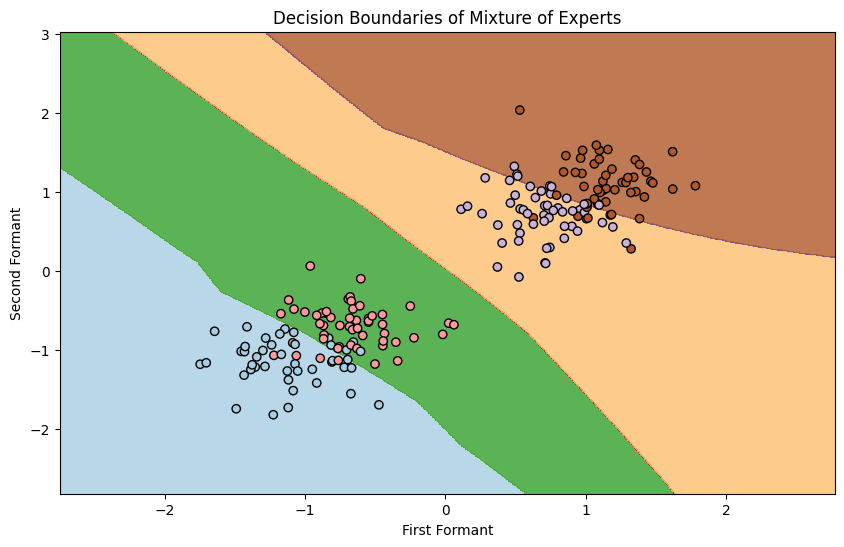

In [8]:
# Visualize decision boundaries
def plot_decision_boundaries(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    grid = np.c_[xx.ravel(), yy.ravel()]
    predictions = np.argmax(model.predict(grid), axis=-1)
    predictions = predictions.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, predictions, alpha=0.8, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
    plt.title("Decision Boundaries of Mixture of Experts")
    plt.xlabel("First Formant")
    plt.ylabel("Second Formant")
    plt.show()

plot_decision_boundaries(moe_model, X_test, y_test)

10127/10127 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


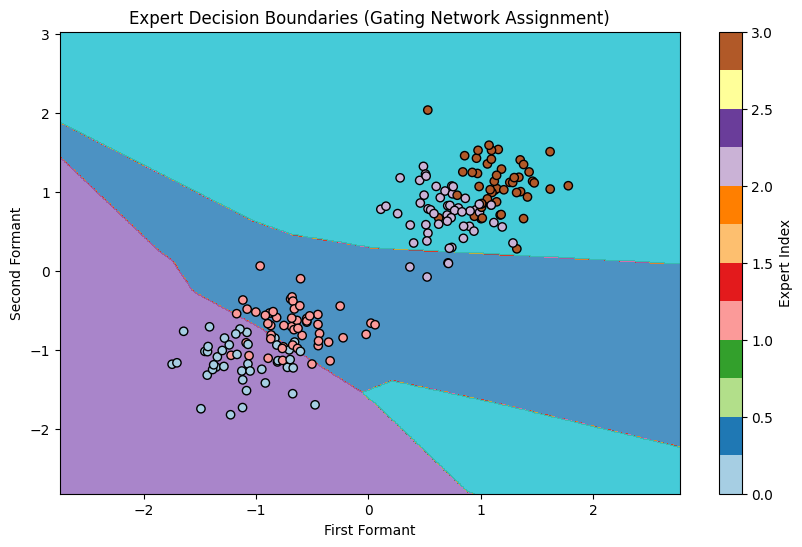

In [9]:
def plot_expert_decision_boundaries(model, X, y, num_experts):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Get gating network probabilities
    gating_probs = model.gating_network.predict(grid)  # Shape: (grid_size, num_experts)
    expert_ownership = np.argmax(gating_probs, axis=-1)  # Assign each point to the most relevant expert

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, expert_ownership.reshape(xx.shape), alpha=0.8, cmap='tab10')  # Visualize expert ownership
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
    plt.title("Expert Decision Boundaries (Gating Network Assignment)")
    plt.xlabel("First Formant")
    plt.ylabel("Second Formant")
    plt.colorbar(label="Expert Index")
    plt.show()

# Call the function to visualize expert decision boundaries
plot_expert_decision_boundaries(moe_model, X_test, y_test, num_experts)

10127/10127 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


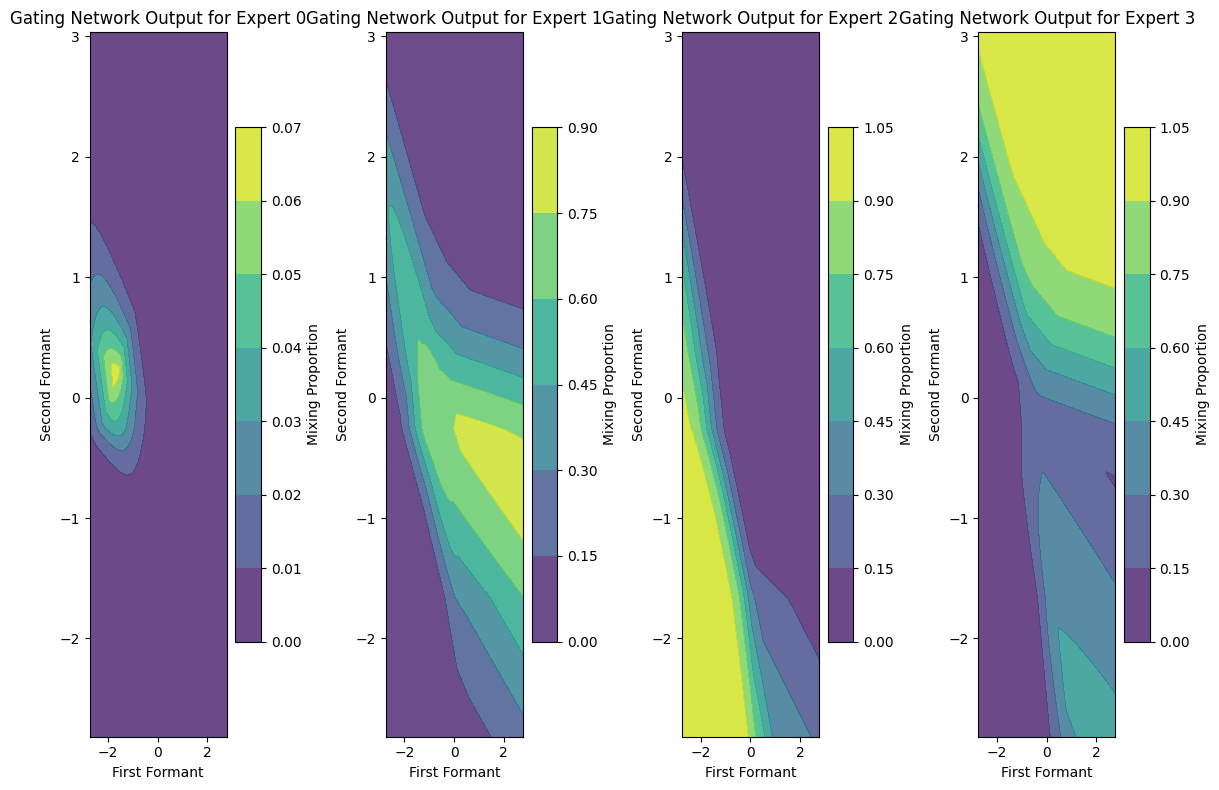

In [10]:
def visualize_gating_network(model, X, num_experts):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict gating probabilities for the grid
    gating_probs = model.gating_network.predict(grid)  # Shape: (grid_size, num_experts)

    # Plot the gating probabilities for each expert
    plt.figure(figsize=(12, 8))
    for i in range(num_experts):
        plt.subplot(1, num_experts, i + 1)
        plt.contourf(xx, yy, gating_probs[:, i].reshape(xx.shape), cmap='viridis', alpha=0.8)
        plt.title(f"Gating Network Output for Expert {i}")
        plt.colorbar(label="Mixing Proportion")
        plt.xlabel("First Formant")
        plt.ylabel("Second Formant")
    plt.tight_layout()
    plt.show()

# Call the function to visualize the gating network
visualize_gating_network(moe_model, X_test, num_experts)